In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string

In [2]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [6]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [7]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [8]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [9]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### Let's continue to brush aside the Named Entity issue in 'overview'

#### Start by removing digits, capital letters and punctuation

In [10]:
alpha = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_and_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

movies['plot_tokens'] = movies['overview'].map(alpha).map(punc_and_lower)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


In [11]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


#### Tokenize plot summaries - start with simple NLTK word_tokenize:

In [12]:
movies['plot_tokens'] = movies['plot_tokens'].map(word_tokenize)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


In [13]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


#### Combine all tokens into one 'corpus' column

In [14]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [15]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,...",adventure animation children comedy fantasy jo...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a...",adventure children fantasy joe_johnston robin_...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ...",comedy romance howard_deutch walter_matthau ja...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th...",comedy drama romance forest_whitaker whitney_h...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr...",comedy charles_shyer steve_martin diane_keaton...


In [16]:
movies['corpus'][0]

'adventure animation children comedy fantasy john_lasseter tom_hanks tim_allen don_rickles jim_varney led by woody andy s toys live happily in his room until andy s birthday brings buzz lightyear onto the scene afraid of losing his place in andy s heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences '

#### Initially, let's skip stemming and just go straight to vectorizing

#### Will try n-grams from 1, 2 and 3 this time

In [17]:
cv1 = CountVectorizer(stop_words='english', ngram_range=(1, 3))

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())

In [18]:
doc_term.shape

(47723, 2864786)

#### The dimensions above only yield about 6% explained variance with 40 PCA components...(ugh)

In [33]:
cv1 = CountVectorizer(stop_words='english', ngram_range=(1, 2))

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())
doc_term.shape

(47723, 1363767)

#### And the above barely breaks 8% explained variance

In [38]:
cv1 = CountVectorizer(stop_words='english', ngram_range=(1, 1))

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())
doc_term.shape

(47723, 152684)

#### And the above barely breaks 14%

#### The trend seems to be fewer columns BEFORE SVD is better - let's continude adjusting params in CountVectorizer

In [42]:
# cv1 = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.01, ngram_range=(1, 3))
cv1 = CountVectorizer(stop_words='english', max_features=50, ngram_range=(1, 1))

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())

In [43]:
doc_term.shape

(47723, 50)

In [44]:
doc_term.head()

,action,adventure,children,comedy,crime,daughter,day,death,documentary,drama,family,fantasy,father,fi,film,finds,friend,friends,girl,group,help,home,horror,life,lives,love,man,mother,mystery,new,old,people,romance,school,sci,son,soon,story,takes,thriller,time,town,war,way,wife,woman,world,year,years,young
0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### Now apply dimensionality reduction to the dataset

In [45]:
svd = TruncatedSVD(n_components=40, n_iter=20, random_state=42)
svd.fit(X_cv1.T)

TruncatedSVD(n_components=40, n_iter=20, random_state=42)

In [46]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.07779393 0.06347439 0.04591917 0.03782428 0.03680344 0.03345193
 0.03235684 0.03128143 0.02895992 0.02760809 0.02678069 0.02597741
 0.0258111  0.02395175 0.02125443 0.020967   0.02008762 0.02014482
 0.01853658 0.01786575 0.01741434 0.01723093 0.01717906 0.01667059
 0.01619289 0.01580436 0.01512359 0.01414401 0.0140112  0.01366825
 0.01322955 0.01316164 0.01269354 0.01211198 0.01190897 0.01182741
 0.01159981 0.01126842 0.0112031  0.01107626]
0.9143704828231133


In [47]:
svd.components_.T.shape

(47723, 40)

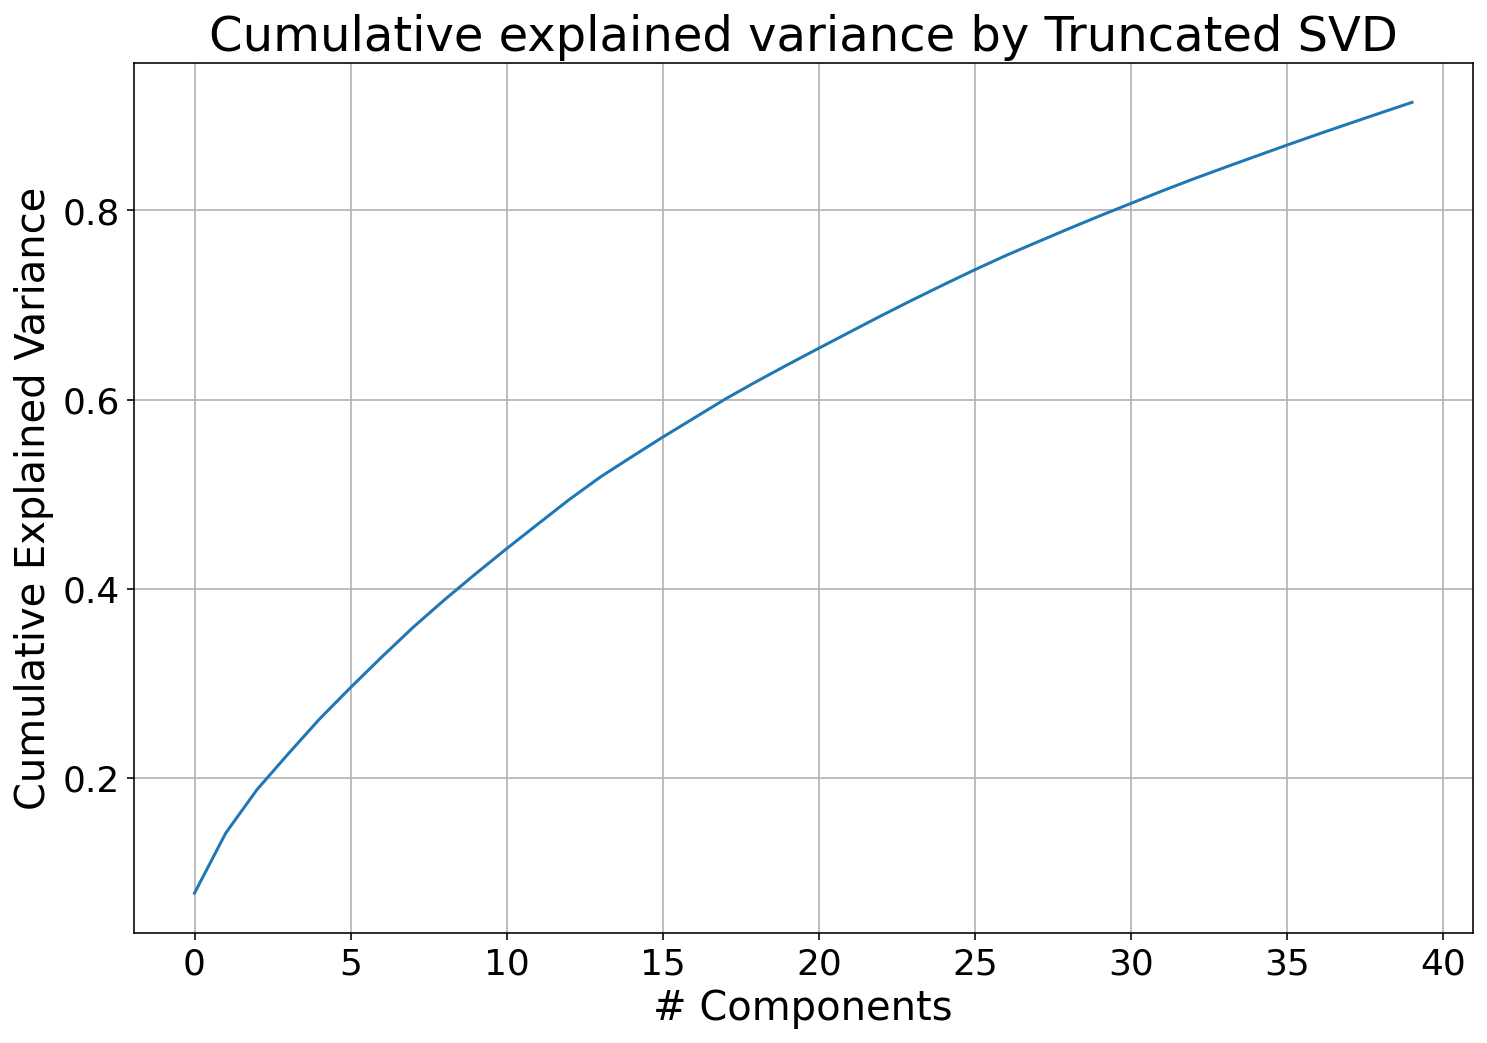

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [49]:
mat = pd.DataFrame(data=svd.components_.T, index=movies.index)
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.002478,0.007710,0.001685,-0.001768,0.003093,0.000754,0.003185,-0.002502,-0.002597,-0.002060,-0.003346,-0.000413,-0.005122,0.000503,0.002406,-0.000036,0.002824,0.015082,0.006529,-0.004199,-0.002298,0.001208,0.002326,-0.001396,0.005605,-0.002694,-0.002959,-0.000433,0.000361,-0.000911,-0.001716,0.002245,-0.003403,0.001418,-0.000560,-0.001522,-0.002467,-0.000668,0.000514,-0.000871
1,0.001825,0.001156,0.003367,0.002285,0.005791,0.005496,0.003724,-0.002975,-0.000626,-0.002785,-0.002828,0.000039,-0.002945,0.002316,0.005052,-0.004548,0.011045,0.015829,0.001780,-0.001525,-0.004176,0.000219,0.006518,-0.001515,0.001951,0.001810,0.001131,-0.004187,0.014430,0.000402,-0.004860,0.000482,-0.004502,0.000389,0.001631,-0.001854,-0.002445,-0.000949,0.000305,-0.000446
2,0.003591,0.007980,-0.001972,-0.001432,-0.000851,-0.000151,0.002086,-0.002460,0.003379,-0.001213,0.007794,0.000023,-0.003250,-0.005788,-0.005641,-0.007668,0.002793,-0.001531,0.000763,0.000199,0.006955,-0.005591,-0.003415,-0.003691,-0.007379,0.001812,-0.006985,-0.000540,-0.001952,-0.000724,-0.002505,-0.000032,-0.002633,0.000345,-0.000684,0.000497,-0.000632,-0.001656,-0.000174,-0.000645
3,0.006812,0.004497,-0.004206,-0.005540,-0.002572,0.000594,-0.002628,0.000815,-0.001698,-0.001026,-0.000254,-0.007196,0.006093,-0.004454,-0.005012,-0.003020,0.001638,0.003942,-0.001849,0.003430,-0.001860,-0.001818,-0.001938,-0.002831,0.000190,-0.001933,-0.002184,-0.003696,-0.000650,0.000334,0.002824,-0.001714,0.011690,-0.009002,-0.000844,-0.002852,0.002382,0.001512,-0.001966,-0.004085
4,0.002527,0.006658,-0.000128,-0.001704,-0.000407,-0.002642,0.002730,0.000537,-0.001723,0.001057,0.001862,-0.000650,0.000667,-0.000388,-0.000879,0.003560,0.001046,-0.000197,0.001503,-0.002645,0.003148,-0.002496,0.004376,0.002970,0.003777,0.011888,0.009235,0.004366,-0.005694,0.000149,0.000028,0.004684,0.001910,-0.003743,0.014081,0.001569,-0.001928,0.009733,-0.009416,-0.003316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,0.007304,-0.003034,-0.002939,0.005535,0.000219,-0.001105,0.016267,-0.003562,0.003458,-0.005576,-0.004391,-0.006205,0.002190,0.019762,-0.007333,0.009304,0.011379,-0.010666,0.000259,-0.004406,0.015456,-0.011474,-0.001907,-0.010161,-0.013250,0.005576,-0.013508,0.007742,0.011050,0.034384,0.008537,0.030894,-0.004528,0.004924,0.001308,0.006380,0.003686,-0.019259,0.022690,-0.014458
47719,0.003453,0.013086,-0.000834,-0.005154,0.000710,-0.004829,0.001047,0.002337,-0.003986,0.003432,0.001039,-0.001345,0.000060,-0.000602,0.001179,0.002593,-0.000485,-0.000612,-0.000517,-0.003630,0.002587,-0.001303,0.002949,0.001694,0.003744,0.008918,0.006384,0.001079,-0.003877,-0.003575,-0.002982,0.000379,0.000073,-0.000685,0.000626,0.001847,-0.002235,-0.005501,0.001305,-0.002539
47720,0.004405,-0.004004,-0.002806,-0.001877,-0.005533,0.004054,0.000386,0.003273,-0.004519,0.003244,-0.005244,0.003960,-0.005138,-0.000406,0.000362,-0.001856,-0.001874,-0.001731,-0.001435,-0.002594,0.004299,0.002296,0.006931,0.000265,-0.001650,-0.005303,0.001350,-0.000246,-0.000720,-0.000445,-0.001724,-0.000539,-0.000200,-0.000675,0.000942,-0.000276,-0.000884,-0.000531,0.000422,-0.001006
47721,0.004180,-0.003060,0.005283,-0.001844,0.002538,0.003135,0.002040,-0.004022,0.003226,0.007634,-0.008388,-0.011123,-0.005425,-0.005210,0.002153,-0.001282,0.000196,-0.001280,0.006637,0.002912,-0.002710,0.002158,0.002549,-0.003905,0.006379,-0.001566,-0.004310,0.001035,-0.000748,-0.006792,0.000257,0.007334,-0.000845,0.000750,0.002506,-0.003497,-0.003579,-0.002265,0.001612,-0.000027


#### Compute Cosine Similarities in this reduced space

In [50]:
del doc_term

cosine_sim = cosine_similarity(mat, mat)
del mat

print(cosine_sim.shape)
print(cosine_sim)
np.save('cosine_similarities.npy', cosine_sim)

(47723, 47723)
[[ 1.          0.65320169  0.00410105 ... -0.02180475  0.306386
  -0.09926415]
 [ 0.65320169  1.         -0.08770207 ... -0.03839612  0.15923349
  -0.09495699]
 [ 0.00410105 -0.08770207  1.         ... -0.11829546 -0.08228003
  -0.07873441]
 ...
 [-0.02180475 -0.03839612 -0.11829546 ...  1.          0.08684277
   0.10398774]
 [ 0.306386    0.15923349 -0.08228003 ...  0.08684277  1.
   0.02345341]
 [-0.09926415 -0.09495699 -0.07873441 ...  0.10398774  0.02345341
   1.        ]]


In [10]:
cosine_sim = np.load('cosine_similarities.npy')

In [12]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = cosine_sim[movie_idx,:].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = cosine_sim[movie_idx, rec_indices]
    return recommendations

In [13]:
recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
2920,Toy Story 2,"[Adventure, Animation, Children, Comedy, Fantasy]",john_lasseter,"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",1.0
3538,The Adventures of Rocky & Bullwinkle,"[Adventure, Animation, Children, Comedy, Fantasy]",des_mcanuff,"[rene_russo, jason_alexander, piper_perabo, ra...",1.0
23645,A Connecticut Yankee in King Arthur's Court,"[Adventure, Children, Comedy, Fantasy]",mel_damski,"[keshia_knight_pulliam, michael_gross, jean_ma...",1.0
23127,Hawaiian Vacation,"[Adventure, Animation, Children, Comedy, Fantasy]",gary_rydstrom,"[tom_hanks, tim_allen, joan_cusack, don_rickles]",1.0
10041,Asterix & Obelix Take on Caesar,"[Adventure, Children, Comedy, Fantasy]",claude_zidi,"[christian_clavier, gérard_depardieu, roberto_...",1.0
20549,Adventures of a Teenage Dragonslayer,"[Adventure, Children, Comedy, Fantasy]",andrew_lauer,"[amy_pietz, eric_lutes, hunter_allan, lea_thom...",1.0
20118,Turbo,"[Adventure, Animation, Children, Comedy, Fantasy]",david_soren,"[ryan_reynolds, paul_giamatti, michael_peña, s...",1.0
31355,Return to Halloweentown,"[Adventure, Children, Comedy, Fantasy]",david_jackson,"[sara_paxton, judith_hoag, lucas_grabeel, joey...",1.0
17410,Asterix and the Vikings,"[Adventure, Animation, Children, Comedy, Fantasy]",stefan_fjeldmark,"[roger_carel, lorànt_deutsch, sara_forestier, ...",1.0
43963,Olaf's Frozen Adventure,"[Adventure, Animation, Children, Comedy, Fantasy]",kevin_deters,"[josh_gad, kristen_bell, idina_menzel, jonatha...",1.0


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [14]:
recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
14415,Nine Dead,"[Crime, Mystery, Thriller]",chris_shadley,"[melissa_joan_hart, john_terry, chip_bent, law...",0.797017
8305,Chase a Crooked Shadow,"[Crime, Film-Noir, Mystery, Thriller]",michael_anderson,"[richard_todd, anne_baxter, herbert_lom, faith...",0.779999
3816,House of Games,"[Crime, Film-Noir, Mystery, Thriller]",david_mamet,"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.779709
37500,Grandmaster,"[Mystery, Thriller]",b._unnikrishnan,"[mohanlal, priyamani, arjun_nandhakumar, babu_...",0.741154
31637,Ricochet,"[Crime, Drama, Mystery, Thriller]",nick_gomez,"[john_corbett, julie_benz, kelly_overton, haaz...",0.728053
16357,Vice,"[Crime, Film-Noir, Mystery, Thriller]",raul_inglis,"[michael_madsen, daryl_hannah, mykelti_william...",0.710596
8838,A Pure Formality,"[Crime, Film-Noir, Mystery, Thriller]",giuseppe_tornatore,"[gérard_depardieu, roman_polanski, sergio_rubi...",0.710596
8531,"Farewell, My Lovely","[Crime, Mystery, Thriller]",dick_richards,"[robert_mitchum, charlotte_rampling, sylvia_mi...",0.710596
1489,L.A. Confidential,"[Crime, Film-Noir, Mystery, Thriller]",curtis_hanson,"[kevin_spacey, russell_crowe, guy_pearce, jame...",0.710596
9279,Hotel Rwanda,"[Drama, War]",terry_george,"[don_cheadle, sophie_okonedo, nick_nolte, fana...",0.702594


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [15]:
recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
30471,The Boy in the Plastic Bubble,[Drama],randal_kleiser,"[john_travolta, glynnis_o'connor, robert_reed,...",1.0
13936,Through the Mist,[Drama],jean-philippe_duval,"[sébastien_ricard, joseph_mesiano, dimitri_sto...",1.0
9294,Beyond the Sea,"[Drama, Musical]",kevin_spacey,"[kevin_spacey, kate_bosworth, john_goodman, bo...",1.0
17470,Shit Year,[Drama],cam_archer,"[ellen_barkin, luke_grimes, bob_einstein, ther...",1.0
29911,Loves Her Gun,[Drama],geoff_marslett,"[trieste_kelly_dunn, francisco_barreiro, ashle...",1.0
39630,When the Heavens Fall…,[Drama],risto_jarva,"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",1.0
27005,Ego,[Drama],lisa_james_larsson,"[martin_wallström, mylaine_hedreul, sissela_ky...",1.0
5706,Quicksilver,[Drama],thomas_michael_donnelly,"[kevin_bacon, jami_gertz, paul_rodríguez, rudy...",1.0
19536,The Wayward Bus,[Drama],victor_vicas,"[joan_collins, jayne_mansfield, dan_dailey, ri...",1.0
10878,Half Nelson,[Drama],ryan_fleck,"[ryan_gosling, shareeka_epps, anthony_mackie, ...",1.0


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [16]:
recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
17,Four Rooms,[Comedy],allison_anders,"[tim_roth, jennifer_beals, antonio_banderas, v...",1.0
22590,Can I Do It Till I Need Glasses?,[Comedy],i._robert_levy,"[roger_behr, mike_callie, joey_camen, moose_ca...",1.0
38907,Uncle Nick,[Comedy],chris_kasick,"[brian_posehn, paget_brewster, missi_pyle, sco...",1.0
13925,The Doctor Takes a Wife,[Comedy],alexander_hall,"[loretta_young, ray_milland, edmund_gwenn, reg...",1.0
3053,Wayne's World 2,[Comedy],stephen_surjik,"[mike_myers, dana_carvey, christopher_walken, ...",1.0
38963,Twenty Million Sweethearts,[Comedy],ray_enright,"[pat_o’brien, dick_powell, ginger_rogers, alle...",1.0
33333,The Dude Goes West,"[Comedy, Western]",kurt_neumann,"[eddie_albert, gale_storm, james_gleason, bart...",1.0
47002,The Con Is On,[Comedy],james_oakley,"[uma_thurman, tim_roth, alice_eve, parker_posey]",1.0
7584,True Love,[Comedy],nancy_savoca,"[annabella_sciorra, ron_eldard, aida_turturro,...",1.0
44802,J-Men Forever,[Comedy],richard_patterson,"[peter_bergman, phil_proctor, m.g._kelly, jack...",1.0


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [17]:
recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
36990,No Stranger Than Love,"[Comedy, Romance]",nick_wernham,"[alison_brie, colin_hanks, justin_chatwin, dyl...",1.0
5453,Continental Divide,"[Comedy, Romance]",michael_apted,"[john_belushi, blair_brown, allen_garfield, ca...",1.0
534,Threesome,"[Comedy, Romance]",andrew_fleming,"[josh_charles, stephen_baldwin, lara_flynn_boy...",1.0
31862,A Rather Complicated Girl,"[Comedy, Romance]",damiano_damiani,"[catherine_spaak, jean_sorel, florinda_bolkan,...",1.0
37584,The Band,"[Comedy, Romance]",anna_brownfield,"[amy_cater, rupert_owen, jimstar, butch_midway]",1.0
32735,Pyaar Kiya To Darna Kya,"[Comedy, Romance]",sohail_khan,"[dharmendra, salman_khan, kajol, arbaaz_khan]",1.0
3147,The Closer You Get,"[Comedy, Romance]",aileen_ritchie,"[ian_hart, sean_mcginley, niamh_cusack, ruth_m...",1.0
33344,If the Shoe Fits,"[Comedy, Romance]",tom_clegg,"[rob_lowe, jennifer_grey, élisabeth_vitali, an...",1.0
16980,The Pleasure Seekers,"[Comedy, Musical, Romance]",jean_negulesco,"[ann-margret, anthony_franciosa, carol_lynley,...",1.0
759,Rendezvous in Paris,"[Comedy, Romance]",éric_rohmer,"[clara_bellar, antoine_basler, mathias_mégard,...",1.0


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [18]:
recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[Crime, Mystery, Thriller]",j._lee_thompson,"[charles_bronson, john_houseman, jacqueline_bi...",1.000000
46229,Chasing Ghosts,"[Crime, Mystery, Thriller]",kyle_dean_jackson,"[michael_madsen, corey_large, shannyn_sossamon...",0.995211
1320,Murder at 1600,"[Crime, Drama, Mystery, Thriller]",dwight_h._little,"[wesley_snipes, diane_lane, alan_alda, daniel_...",0.957918
607,Primal Fear,"[Crime, Drama, Mystery, Thriller]",gregory_hoblit,"[richard_gere, laura_linney, john_mahoney, alf...",0.954355
39352,Swept Under,"[Crime, Drama, Thriller]",michel_poulette,"[aaron_ashmore, andré_bédard, stephen_bogaert,...",0.951433
25003,Beck 28 - The Family,"[Crime, Mystery, Thriller]",mårten_klingberg,"[peter_haber, mikael_persbrandt, ingvar_hirdwa...",0.931131
7558,The Adventures of Sherlock Holmes,"[Crime, Mystery, Thriller]",alfred_l._werker,"[basil_rathbone, nigel_bruce, ida_lupino, alan...",0.919767
37668,Seven Sinners,"[Crime, Thriller]",albert_de_courville,"[edmund_lowe, constance_cummings, thomy_bourde...",0.917968
18845,Fog Over Frisco,"[Crime, Mystery, Thriller]",william_dieterle,"[bette_davis, donald_woods, margaret_lindsay, ...",0.912505
49,The Usual Suspects,"[Crime, Mystery, Thriller]",bryan_singer,"[stephen_baldwin, kevin_spacey, gabriel_byrne,...",0.912121


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [19]:
recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
30768,Captain America,"[Action, Adventure, Sci-Fi]",elmer_clifton,"[dick_purcell, lorna_gray, lionel_atwill, char...",1.0
4737,Spacehunter: Adventures in the Forbidden Zone,"[Action, Adventure, Sci-Fi]",lamont_johnson,"[peter_strauss, molly_ringwald, michael_ironsi...",1.0
18863,Journey to Saturn,"[Action, Adventure, Animation, Sci-Fi]",kresten_vestbjerg_andersen,"[casper_christensen, frank_hvam, ali_kazim, ib...",1.0
9422,Double Dragon,"[Action, Adventure, Sci-Fi]",james_yukich,"[mark_dacascos, scott_wolf, robert_patrick, kr...",1.0
9804,Star Wars: Episode III - Revenge of the Sith,"[Action, Adventure, Sci-Fi]",george_lucas,"[hayden_christensen, ewan_mcgregor, natalie_po...",1.0
41282,Valerian and the City of a Thousand Planets,"[Action, Adventure, Sci-Fi]",luc_besson,"[dane_dehaan, cara_delevingne, clive_owen, rih...",1.0
41305,"Abraxas, Guardian of the Universe","[Action, Adventure, Sci-Fi]",damian_lee,"[jesse_ventura, sven-ole_thorsen, damian_lee, ...",1.0
13137,Flash Gordon,"[Action, Adventure, Sci-Fi]",frederick_stephani,"[buster_crabbe, jean_rogers, frank_shannon, ch...",1.0
307,Stargate,"[Action, Adventure, Sci-Fi]",roland_emmerich,"[kurt_russell, james_spader, jaye_davidson, vi...",1.0
40536,Moontrap: Target Earth,"[Action, Adventure, Sci-Fi]",robert_dyke,"[sarah_butler, damon_dayoub, charles_shaughnes...",1.0


#### Will try Stemming first (and Lemmatization as an alternative later); Start with PorterStemmer